# SqueezeNet

This notebook tries to reproduce the results from Turi Create with Keras, using the same approach. 

Note that Turi Create uses L-BFGS to train the logistic regression, but we use the Adam optimizer.

In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers

Using TensorFlow backend.


In [2]:
image_width = 227
image_height = 227

## Load SqueezeNet

Keras does not come with a pre-trained version of SqueezeNet. This notebook used the version from https://github.com/rcmalli/keras-squeezenet. The `keras_squeezenet` folder should be in your path. Creating a `SqueezeNet()` instance downloads the weights and copies them to `~/.keras/models`. 

In [3]:
from keras_squeezenet import SqueezeNet

In [4]:
model = SqueezeNet(include_top=True, input_shape=(image_height, image_width, 3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
5062656/5059384 [==============================] - 1s 0us/step


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 113, 113, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Note that this model has a `GlobalAveragePooling2D` layer at the end, which is followed directly by an `Activation` layer that performs the softmax. Turi Create uses the 1000 outputs from the global average pooling layer and adds the logistic regresion on top of that, so that's what we'll do too.

We don't need that final Activation layer, so drop it from the model.

In [6]:
model.layers.pop()
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []

## Image preprocessing

The version SqueezeNet we're using requires regular imagenet preprocessing.

In [7]:
images_dir = "snacks/"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"

In [8]:
from keras.applications.imagenet_utils import preprocess_input

In [9]:
from keras.preprocessing import image
img = image.load_img(train_data_dir + "apple/0eeeec32799af3da.jpg", target_size=(image_width, image_height))

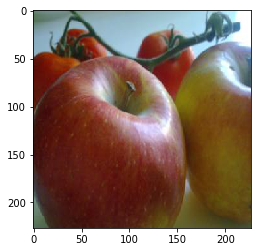

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)

Preprocess the image:

In [11]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Look at the feature vector that SqueezeNet extracted for this image:

In [12]:
preds = model.predict(x)
preds.shape

(1, 1000)

In [13]:
preds

array([[12.863284 , 18.953522 , 11.361242 ,  8.6906   , 10.938829 ,
        13.93599  , 11.659559 , 10.087726 , 11.887223 ,  3.8610218,
        13.3836775, 14.853419 , 13.5803385,  9.553555 , 10.903888 ,
        11.265902 , 12.441345 ,  7.5033636,  9.203907 , 10.471996 ,
        10.506223 , 11.451153 , 12.080322 , 10.5620165,  6.177545 ,
        11.250592 , 10.518916 , 11.529224 , 11.915842 , 15.897635 ,
        12.034616 , 13.619373 , 15.752699 , 10.420132 ,  6.780358 ,
         8.092216 , 13.138922 ,  8.684971 ,  9.589348 ,  6.2118692,
        13.26607  , 11.996024 ,  8.738823 ,  9.647164 , 11.72468  ,
         6.449513 , 11.213063 ,  9.107146 ,  4.3942475,  3.5552535,
         4.9402776,  4.251671 , 11.862432 , 11.082634 ,  8.193122 ,
         9.506156 ,  9.272615 ,  9.357199 ,  6.3962755,  9.342859 ,
        12.411736 , 12.226518 , 11.78542  , 10.917459 , 11.332937 ,
         9.939273 , 10.32182  ,  7.446245 ,  8.726882 ,  7.8956466,
         5.836758 , 10.467161 ,  5.2907653,  7.8

What do these numbers mean? No idea. They are the features that SqueezeNet has extracted from the image. Each number represents how well the image matches with the 1000 high-level patterns that SqueezeNet has learned to detect. The only way to make sense out of these numbers is to add a logistic regression on top, so that the model can learn to match these extracted features to our 20 classes.

(Actually, for this particular version of SqueezeNet the numbers _can_ be directly interpreted. This model was trained on the ImageNet dataset that has 1000 categories of objects. It is no coincidence that SqueezeNet outputs 1000 numbers. Because the `GlobalAveragePooling` layer is directly followed by a softmax, each of these 1000 numbers indicates the likelihood that the image belongs to one of those classes. For the example image, `np.argmax(preds)` gives 948, which is the category for "Granny Smith", which is a pretty good prediction. The high-level features that SqueezeNet has learned to detect *are* the 1000 ImageNet classes. However, this only works because the SqueezeNet model does not have a `Dense` layer following the global pooling layer.)

## Create bottleneck features

Just like Turi Create, we will now extract the features for all the training images. This creates a new NumPy array of shape `(4838, 1000)` because we have 4838 training images and for each image SqueezeNet will extract a 1000-element feature vector.

In [14]:
batch_size = 128
num_classes = 20

In [15]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [16]:
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 4838 images belonging to 20 classes.


In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
bottleneck_features_train = model.predict_generator(train_generator,
                                                    steps=len(train_generator),
                                                    workers=8, verbose=1)

38/38 [==============================] - 4s 97ms/step


In [19]:
bottleneck_features_train.shape

(4838, 1000)

Look at one of the extracted feature vectors, to make sure it looks similar to the one we saw before. If it's totally different, then something might be wrong with the generator perhaps. Fortunately, it all looks fine:

In [20]:
bottleneck_features_train[0]

array([ 5.554354 , 11.1816845,  8.384514 ,  4.1432214,  6.0634656,
        9.994695 ,  7.1865516, 12.655218 , 12.918187 , 10.276096 ,
       13.043045 , 11.249888 , 16.37934  , 12.523043 , 14.783462 ,
       10.583266 ,  9.7254   ,  9.222766 ,  8.571495 ,  8.135515 ,
       11.025199 ,  8.876048 , 10.072398 , 12.038544 ,  6.9884048,
        7.854167 , 11.397168 , 11.207301 ,  9.283547 ,  9.3738365,
        8.923479 , 11.459018 , 15.0841465,  8.878992 ,  7.2233915,
        9.928623 , 11.179128 , 11.310319 , 12.459506 , 12.992306 ,
       11.078805 , 14.436002 , 11.245947 ,  8.717669 , 13.206964 ,
        8.468899 ,  9.660551 ,  9.948654 ,  9.451983 ,  9.984784 ,
        9.155918 ,  7.920055 , 11.453991 ,  9.409739 ,  8.775815 ,
        7.98386  , 10.458867 , 10.9599085,  9.477709 ,  8.110986 ,
       11.11536  ,  8.872024 ,  9.23906  , 10.860873 ,  8.671624 ,
       10.009112 , 11.553814 ,  8.821443 ,  9.512453 ,  7.1829395,
       11.388935 , 12.970117 ,  7.825059 , 14.329113 , 12.2885

Save these features to a file, so we only have to extract them once.

In [21]:
features_dir = "features/"

if not os.path.exists(features_dir):
    os.makedirs(features_dir)

In [22]:
np.save(features_dir + "bottleneck_features_train.npy", bottleneck_features_train)

The generator has `class_mode=None` because we don't care about passing in the classes as target to `predict_generator()`. However, we do need to know the target for each image, so we also save that.

In [23]:
np.save(features_dir + "train_targets.npy", train_generator.classes)

Also save the features for the images from the validation set.

In [24]:
val_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 955 images belonging to 20 classes.


In [25]:
bottleneck_features_val = model.predict_generator(val_generator, steps=len(val_generator), workers=8, verbose=1)

8/8 [==============================] - 1s 127ms/step


In [27]:
bottleneck_features_val.shape

(955, 1000)

In [28]:
np.save(features_dir + "bottleneck_features_val.npy", bottleneck_features_val)
np.save(features_dir + "val_targets.npy", val_generator.classes)

Also save the features for the images from the test set.

In [29]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 952 images belonging to 20 classes.


In [30]:
bottleneck_features_test = model.predict_generator(test_generator, steps=len(test_generator), workers=8, verbose=1)

8/8 [==============================] - 1s 127ms/step


In [31]:
bottleneck_features_test.shape

(952, 1000)

In [32]:
np.save(features_dir + "bottleneck_features_test.npy", bottleneck_features_test)
np.save(features_dir + "test_targets.npy", test_generator.classes)

## Create a logistic regression classifier

The inputs to this logistic regression are the features we just computed.

In [33]:
train_data = np.load(features_dir + "bottleneck_features_train.npy")
train_labels = np.load(features_dir + "train_targets.npy")
val_data = np.load(features_dir + "bottleneck_features_val.npy")
val_labels = np.load(features_dir + "val_targets.npy")
test_data = np.load(features_dir + "bottleneck_features_test.npy")
test_labels = np.load(features_dir + "test_targets.npy")

In [34]:
from keras import regularizers

Create a very simple model that exists of just a `Dense` layer with a softmax activation.

In [35]:
top_model = Sequential()

top_model.add(Dense(num_classes, input_shape=train_data.shape[1:], 
                    kernel_regularizer=regularizers.l2(0.1), 
                    activation="softmax"))

top_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=["accuracy"])

In [36]:
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                20020     
Total params: 20,020
Trainable params: 20,020
Non-trainable params: 0
_________________________________________________________________


Note that the Turi Create model has 19019 parameters, not 20020. They train their logistic regression in a slightly different way. The end result will be the same, though.

## Create a validation set

Keras can automatically choose a portion of the training data to be the validation set, but it's more fair for making comparisons between training runs if we create our own validation set ahead of time.

We can do this by taking a random portion of the training set and using it as the validation set. This is what Create ML and Turi Create do:

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, train_size=0.9)

In [33]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4354, 1000), (484, 1000), (4354,), (484,))

Or we can use the fixed validation set, which will be more reliable.

In [37]:
X_train = train_data
y_train = train_labels
X_val = val_data
y_val = val_labels

In [38]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4838, 1000), (955, 1000), (4838,), (955,))

## Train the logistic regression

Create a callback that will automatically lower the learning rate when the validation loss gets stuck.

In [39]:
from keras import callbacks

my_callbacks = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                                patience=10, verbose=1, mode="auto", 
                                epsilon=0.0001, cooldown=0, min_lr=0),
]

Train for a bunch of epochs and see what happens...

In [40]:
histories = []

In [41]:
histories.append(top_model.fit(X_train, y_train,
                               batch_size=batch_size,
                               epochs=200,
                               callbacks=my_callbacks,
                               validation_data=(X_val, y_val)))

Instructions for updating:
Use tf.cast instead.
Train on 4838 samples, validate on 955 samples
Epoch 1/200
4838/4838 [==============================] - 0s 45us/step - loss: 14.9513 - acc: 0.0595 - val_loss: 12.3982 - val_acc: 0.0848
Epoch 2/200
4838/4838 [==============================] - 0s 7us/step - loss: 10.8664 - acc: 0.1331 - val_loss: 9.8360 - val_acc: 0.1717
Epoch 3/200
4838/4838 [==============================] - 0s 7us/step - loss: 8.9313 - acc: 0.2108 - val_loss: 8.2560 - val_acc: 0.2314
Epoch 4/200
4838/4838 [==============================] - 0s 7us/step - loss: 7.6992 - acc: 0.2821 - val_loss: 7.6397 - val_acc: 0.2743
Epoch 5/200
4838/4838 [==============================] - 0s 7us/step - loss: 7.1695 - acc: 0.3303 - val_loss: 7.1548 - val_acc: 0.3309
Epoch 6/200
4838/4838 [==============================] - 0s 7us/step - loss: 6.8351 - acc: 0.3787 - val_loss: 6.9352 - val_acc: 0.3518
Epoch 7/200
4838/4838 [==============================] - 0s 7us/step - loss: 6.5546 - acc: 

Epoch 59/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.4258 - acc: 0.7342 - val_loss: 2.7917 - val_acc: 0.6220
Epoch 60/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.3804 - acc: 0.7360 - val_loss: 2.7490 - val_acc: 0.6398
Epoch 61/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.3606 - acc: 0.7416 - val_loss: 2.7381 - val_acc: 0.6335
Epoch 62/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.3417 - acc: 0.7425 - val_loss: 2.7157 - val_acc: 0.6356
Epoch 63/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.3019 - acc: 0.7439 - val_loss: 2.7036 - val_acc: 0.6346
Epoch 64/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.2946 - acc: 0.7402 - val_loss: 2.7154 - val_acc: 0.6230
Epoch 65/200
4838/4838 [==============================] - 0s 7us/step - loss: 2.2621 - acc: 0.7410 - val_loss: 2.6441 - val_acc: 0.6314
Epoch 66/200
4838/4838 [========================

4838/4838 [==============================] - 0s 7us/step - loss: 1.4032 - acc: 0.7943 - val_loss: 1.8685 - val_acc: 0.6482
Epoch 120/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.3914 - acc: 0.7945 - val_loss: 1.8221 - val_acc: 0.6555
Epoch 121/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.3882 - acc: 0.7925 - val_loss: 1.8343 - val_acc: 0.6618
Epoch 122/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.4195 - acc: 0.7807 - val_loss: 1.8371 - val_acc: 0.6565
Epoch 123/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.3847 - acc: 0.7894 - val_loss: 1.8108 - val_acc: 0.6482
Epoch 124/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.3557 - acc: 0.8053 - val_loss: 1.7855 - val_acc: 0.6555
Epoch 125/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.3526 - acc: 0.7954 - val_loss: 1.7670 - val_acc: 0.6764
Epoch 126/200
4838/4838 [==============================

Epoch 179/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0508 - acc: 0.8090 - val_loss: 1.5156 - val_acc: 0.6660
Epoch 180/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0541 - acc: 0.8057 - val_loss: 1.5171 - val_acc: 0.6681
Epoch 181/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0555 - acc: 0.8084 - val_loss: 1.5149 - val_acc: 0.6576
Epoch 182/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0423 - acc: 0.8096 - val_loss: 1.5187 - val_acc: 0.6628
Epoch 183/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0459 - acc: 0.8084 - val_loss: 1.5062 - val_acc: 0.6586
Epoch 184/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0254 - acc: 0.8208 - val_loss: 1.4946 - val_acc: 0.6639
Epoch 185/200
4838/4838 [==============================] - 0s 7us/step - loss: 1.0313 - acc: 0.8119 - val_loss: 1.4965 - val_acc: 0.6754
Epoch 186/200
4838/4838 [================

The model is certainly learning but it doesn't look like it's done training yet, so train for more epochs. Since our logistic regression is really small and all the training data fits into RAM, training is very quick.

In [42]:
histories.append(top_model.fit(X_train, y_train,
                               batch_size=batch_size,
                               epochs=200,
                               callbacks=my_callbacks,
                               validation_data=(X_val, y_val)))

Train on 4838 samples, validate on 955 samples
Epoch 1/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.9889 - acc: 0.8160 - val_loss: 1.4458 - val_acc: 0.6691
Epoch 2/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.9835 - acc: 0.8160 - val_loss: 1.4618 - val_acc: 0.6586
Epoch 3/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.9913 - acc: 0.8080 - val_loss: 1.4666 - val_acc: 0.6545
Epoch 4/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.9920 - acc: 0.8109 - val_loss: 1.4765 - val_acc: 0.6618
Epoch 5/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.9834 - acc: 0.8167 - val_loss: 1.4782 - val_acc: 0.6513
Epoch 6/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.9822 - acc: 0.8142 - val_loss: 1.4656 - val_acc: 0.6649
Epoch 7/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.9800 - acc: 0.8138 - val_loss: 1.4430 - val_acc: 0.6649
Epoch 8

Epoch 60/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8645 - acc: 0.8431 - val_loss: 1.3588 - val_acc: 0.6806
Epoch 61/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8648 - acc: 0.8460 - val_loss: 1.3317 - val_acc: 0.6806
Epoch 62/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.8615 - acc: 0.8444 - val_loss: 1.3469 - val_acc: 0.6743
Epoch 63/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8621 - acc: 0.8481 - val_loss: 1.3372 - val_acc: 0.6869
Epoch 64/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.8631 - acc: 0.8481 - val_loss: 1.3369 - val_acc: 0.6827
Epoch 65/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8589 - acc: 0.8485 - val_loss: 1.3381 - val_acc: 0.6796
Epoch 66/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.8600 - acc: 0.8473 - val_loss: 1.3370 - val_acc: 0.6880
Epoch 67/200
4838/4838 [========================

4838/4838 [==============================] - 0s 7us/step - loss: 0.8434 - acc: 0.8528 - val_loss: 1.3185 - val_acc: 0.6827
Epoch 119/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8433 - acc: 0.8537 - val_loss: 1.3182 - val_acc: 0.6817
Epoch 120/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8441 - acc: 0.8547 - val_loss: 1.3180 - val_acc: 0.6869
Epoch 121/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.8432 - acc: 0.8549 - val_loss: 1.3181 - val_acc: 0.6838
Epoch 122/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8429 - acc: 0.8545 - val_loss: 1.3180 - val_acc: 0.6848
Epoch 123/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8433 - acc: 0.8561 - val_loss: 1.3192 - val_acc: 0.6827

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 124/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8423 - acc: 0.8547 - val_loss: 

4838/4838 [==============================] - 0s 7us/step - loss: 0.8410 - acc: 0.8547 - val_loss: 1.3176 - val_acc: 0.6827
Epoch 176/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8410 - acc: 0.8549 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00176: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 177/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8409 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6838
Epoch 178/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8409 - acc: 0.8545 - val_loss: 1.3175 - val_acc: 0.6827
Epoch 179/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8409 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827
Epoch 180/200
4838/4838 [==============================] - 0s 7us/step - loss: 0.8409 - acc: 0.8545 - val_loss: 1.3175 - val_acc: 0.6827
Epoch 181/200
4838/4838 [==============================] - 0s 8us/step - loss: 0.8409 - acc: 0.8545 - val_loss:

What was the accuracy on the last epoch? (Note that the last epoch isn't necessarily the best one.)

In [43]:
histories[-1].history["acc"][-1], histories[-1].history["val_acc"][-1]

(0.8546920216936078, 0.6827225119031537)

From now on, save a checkpoint whenever the `val_acc` improves:

In [44]:
checkpoint_dir = "checkpoints/squeezenet/"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [45]:
my_callbacks += [
    callbacks.ModelCheckpoint(checkpoint_dir + "multisnacks.{epoch:02d}-{val_loss:.2f}-{val_acc:.4f}.hdf5", 
                              monitor="val_acc", verbose=1, save_best_only=True, save_weights_only=False, 
                              mode="auto", period=1)
]

In [46]:
histories.append(top_model.fit(X_train, y_train,
                               batch_size=batch_size,
                               epochs=200,
                               callbacks=my_callbacks,
                               validation_data=(X_val, y_val)))

Train on 4838 samples, validate on 955 samples
Epoch 1/200
4838/4838 [==============================] - 0s 9us/step - loss: 0.8409 - acc: 0.8545 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00001: val_acc improved from -inf to 0.68272, saving model to checkpoints/squeezenet/multisnacks.01-1.32-0.6827.hdf5
Epoch 2/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8409 - acc: 0.8545 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00002: val_acc did not improve from 0.68272
Epoch 3/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8409 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00003: val_acc did not improve from 0.68272
Epoch 4/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8409 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00004: val_acc did not improve from 0.68272
Epoch 5/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8409 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.68

4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00042: val_acc did not improve from 0.68272
Epoch 43/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00043: val_acc did not improve from 0.68272
Epoch 44/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00044: val_acc did not improve from 0.68272
Epoch 45/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00045: val_acc did not improve from 0.68272
Epoch 46/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00046: val_acc did not improve from 0.68272
Epoch 47/200
4838/4838 [==============================] - 0s 10us/step - 

4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00084: val_acc did not improve from 0.68272
Epoch 85/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00085: val_acc did not improve from 0.68272
Epoch 86/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00086: val_acc did not improve from 0.68272
Epoch 87/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00087: val_acc did not improve from 0.68272
Epoch 88/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00088: val_acc did not improve from 0.68272
Epoch 89/200
4838/4838 [==============================] - 0s 10us/step - 

4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00126: val_acc did not improve from 0.68272
Epoch 127/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00127: val_acc did not improve from 0.68272
Epoch 128/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00128: val_acc did not improve from 0.68272
Epoch 129/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00129: val_acc did not improve from 0.68272
Epoch 130/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00130: val_acc did not improve from 0.68272
Epoch 131/200
4838/4838 [==============================] - 0s 10us/st


Epoch 00167: val_acc did not improve from 0.68272
Epoch 168/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00168: val_acc did not improve from 0.68272
Epoch 169/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00169: val_acc did not improve from 0.68272
Epoch 170/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00170: val_acc did not improve from 0.68272
Epoch 171/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss: 1.3175 - val_acc: 0.6827

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1.8626451021765827e-13.

Epoch 00171: val_acc did not improve from 0.68272
Epoch 172/200
4838/4838 [==============================] - 0s 10us/step - loss: 0.8408 - acc: 0.8547 - val_loss

Combine the histories from the separate training passes:

In [47]:
def combine_histories():
    history = { "loss": [], "val_loss": [], "acc": [], "val_acc": [] }
    for h in histories:
        for k in history.keys():
            history[k] += h.history[k]
    return history

In [48]:
history = combine_histories()

Plot the loss curve:

In [49]:
def plot_loss(history):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])
    plt.show()

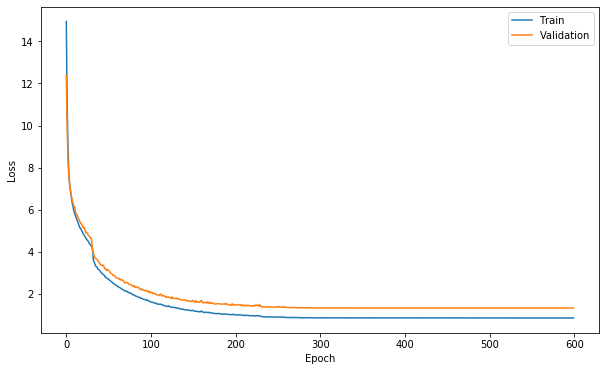

In [50]:
plot_loss(history)

Note how the loss went down every time the `ReduceLROnPlateau` callback dropped the learning rate. The validation loss is pretty close to the training loss, so we're not overfitting.

In [51]:
def plot_accuracy(history):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history["acc"])
    plt.plot(history["val_acc"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

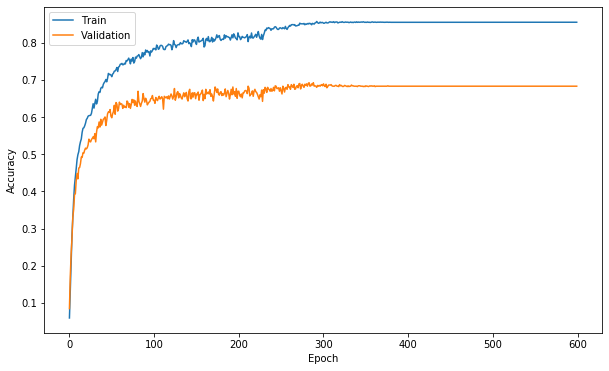

In [52]:
plot_accuracy(history)

The validation accuracy doesn't really seem to be improving very much anymore. That means we're done training!

## Load the best model

The `ModelCheckpoint` callback has saved a copy of the model every time the validation accuracy improved, so grab the last one it saved.

In [53]:
from keras.models import load_model

In [54]:
best_model = load_model(checkpoint_dir + "multisnacks.01-1.32-0.6827.hdf5")

In [55]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                20020     
Total params: 20,020
Trainable params: 20,020
Non-trainable params: 0
_________________________________________________________________


Evaluate on the test data:

In [56]:
best_model.evaluate(test_data, test_labels, batch_size, verbose=1)

952/952 [==============================] - 0s 33us/step


[1.2480115990678804, 0.6995798329345319]

69% correct, very similar to Turi Create's results.